In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from pyksc import ksc

In [2]:
filename = '/home/wagnernegrao/Documents/dados_growth_curve/projetos_concatenados/akka.csv'

In [3]:
df = pd.read_csv(filename, usecols=['Commit', 'Date', 'Project', 'blank', 'code', 'comment', 'filename', 'language'])
df['Date'] = df.Date.apply(lambda date: date.replace('.csv', ''))

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

In [5]:

dfx = df.loc[df['code'] >= 13196]

files_list = dfx.filename.tolist()

unique_files = []

for i in files_list:
    if(i not in unique_files):
        unique_files.append(i)

In [6]:
unique_files[0]

'/home/wagnernegrao/projetos_large_files/akka/akka-protobuf/src/main/java/akka/protobuf/DescriptorProtos.java'

In [9]:
df['code'] = df.code.apply(lambda code: float(code))

dfs = []
for path in unique_files:
     dfs.append(df.loc[df['filename'] == path])

In [97]:
"""
d = {'Date': frame.Date.tolist(), 'Code': frame.code.tolist()}
d['Code'].insert(0,0)
d['Date'].insert(0,d['Date'][0])

dfx2 = pd.DataFrame(data=d)

dfx2['Code'] = dfx2.Code.apply(lambda code: float(code))
"""

"\nd = {'Date': frame.Date.tolist(), 'Code': frame.code.tolist()}\nd['Code'].insert(0,0)\nd['Date'].insert(0,d['Date'][0])\n\ndfx2 = pd.DataFrame(data=d)\n\ndfx2['Code'] = dfx2.Code.apply(lambda code: float(code))\n"

In [79]:
tm_series = [] 
years = [] 
for df in dfs:
    tm_series.append(df.code.tolist())
    years.append(df.Date.dt.year.tolist())

In [82]:
flag = False

while(flag != True):
    for serie in tm_series:
        #print('Serie: ', len(serie))
        for i in range(len(serie)):
            if(i >= 25):
                #print('=> ', i)
                serie.pop(i)
                break
    for serie in tm_series:
        if(len(serie) == 25):
            flag = True
        else:
            flag = False
            
for i in tm_series:
    print(len(i))

25
25
25
25
25


In [98]:
for serie in tm_series:
    serie.insert(0,0)

AttributeError: 'numpy.ndarray' object has no attribute 'insert'

In [ ]:
"""
Logica para ter a quantidade de anos igual ao tamanho da lista
"""

data = [] 

for ano in years:
    for i in ano:
        if i not in data:
            data.append(i)



cont = 0 
while(len(data) != 26):
    
    data.append(data[cont])
    cont+=1

data = sorted(data)

In [93]:
tm_series = np.array(tm_series)

clusters_by_time_series = {}

centroids, assign, best_shift, cent_dists = ksc.ksc(tm_series, 3)


In [94]:
if assign is not None:
    for series, cluster in zip(tm_series, assign):
        if cluster in clusters_by_time_series.keys():
            clusters_by_time_series[cluster].append(series)
        else:
            clusters_by_time_series[cluster] = [series]

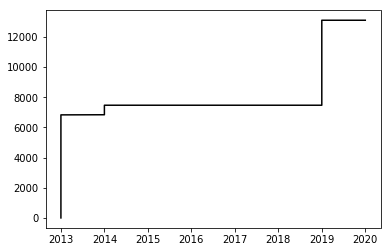

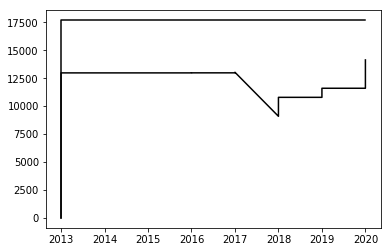

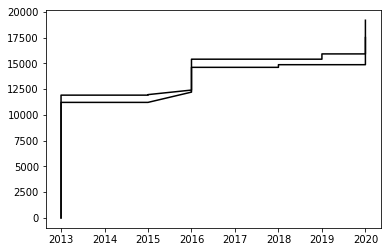

In [99]:
weeks = None 

for cluster in clusters_by_time_series.keys():
    figure = plt.figure()

    for project_time_series in clusters_by_time_series[cluster]:
        if weeks is None:
            weeks = [-i for i in range(len(project_time_series) - 1, -1, -1)]

        project_time_series = [0 if i == 0.1 else int(i) for i in project_time_series]

        plt.plot(data, project_time_series, color='black')
        
        figure.savefig('curva_crescimento.png', bbox_inches='tight', format='png', dpi=1000)

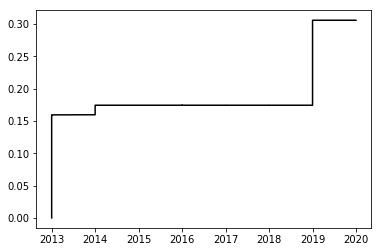

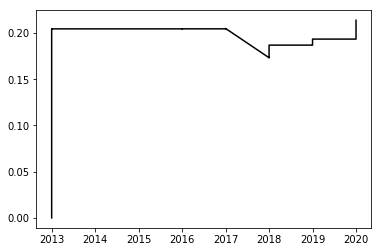

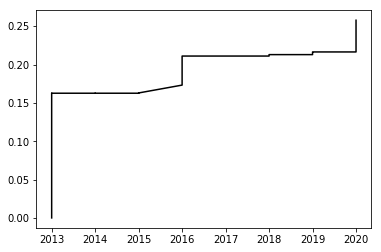

In [96]:

for cluster, centroid in zip(range(0, 3), centroids):
    growth_rate = centroid[0] + centroid[-1] * 100
    #report_file.write(str(cluster) + ': ' + str(centroid) + ' (Growth:' + str("{0:.2f}".format(growth_rate)) + ')\n')

    if weeks is None:
        weeks = [-i for i in range(len(centroid) - 1, -1, -1)]

    figure = plt.figure()
    plt.plot(data, centroid, color='black')